In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.basics import *
from fastai.callback.all import *
from fastai.vision.all import *
import torch
from PIL import Image

#Para rodar no meu pc a VM Instance
#gcloud compute ssh jupyter@my-fastai-instance -- -L 8080:localhost:8080

# Testar to_fp16, size diferente, ir fazendo transfer learning de sizes diferentes, fine_tunning

# DATA

### Dataset

In [4]:
path = './database'
path_anno = path + '/gt'
path_img = path + '/done'

#funcao que pega a imagem de anotacoes correspondente, dado a imagem original de entrada
get_y_fn = lambda x : path_anno + '/' + f'{x.stem}_GT.png'

In [16]:
np.random.seed(2) #mesma semente para todas as vezes que executar

label_fnames = get_image_files(path_anno)
print(label_fnames[:3])
fnames = get_image_files(path_img)
print(fnames[:3])

[Path('database/gt/0_GT.png'), Path('database/gt/100_GT.png'), Path('database/gt/101_GT.png')]
[Path('database/done/0.jpg'), Path('database/done/1.jpg'), Path('database/done/10.jpg')]


In [5]:
#redimensiona todas as imagens e salva novamente

#for file in fnames:
#    image = Image.open(file)
#    image = image.resize((350, 350))
#    image.save(file)

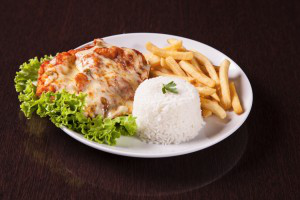

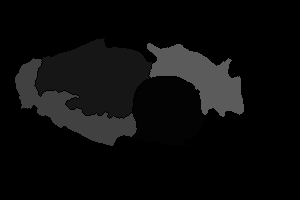

In [19]:

img = Image.open(fnames[10])
display(img)

img1 = Image.open(get_y_fn(fnames[10]))
display(img1)

In [12]:
codes = np.loadtxt(path + '/' + 'classesNumber.txt', dtype=str, delimiter='\n',encoding='utf')
codes = [code.split(": ")[1] for code in codes] #pega apenas o nome de cada classe e ignora o ID

['NaoAlimento',
 'AlimentoNaoRegistrado',
 'Arroz Integral',
 'Arroz Branco',
 'FeijÃ£o',
 'Arroz Integral e Feijao',
 'Arroz Branco e Feijao',
 'Arroz Carreteiro',
 'MacarrÃ£o',
 'Batata',
 'Batata Palha',
 'Batata Doce',
 'Pure de Batata',
 'Mandioca',
 'Inhame',
 'GrÃ£o de Bico',
 'Cuscuz',
 'Farofa',
 'FeijÃ£o Tropeiro',
 'Pure de GrÃ£o de Bico',
 'Lentilha',
 'Batata Baroa',
 'Lasanha',
 'Nhoque',
 'Risoto',
 'Torta Salgada',
 'PirÃ£o',
 'Milho',
 'Maionese',
 'Creme de Milho',
 'Escondidinho de Carne',
 'Banana',
 'Manga',
 'MamÃ£o',
 'PÃªssego',
 'Abacate',
 'MaÃ§Ã£',
 'Pera',
 'Abacaxi',
 'Ameixa',
 'Amora',
 'Morango',
 'Melancia',
 'Cereja',
 'Uva',
 'MelÃ£o',
 'Goiaba',
 'Laranja sem Casca',
 'Salada de Frutas',
 'PÃ£o Integral',
 'PÃ£o Branco',
 'PÃ£o de Queijo',
 'Bolo',
 'Carne',
 'Cozido de Carne',
 'Strognoff',
 'LinguiÃ§a',
 'Carne moÃ\xadda',
 'Peixe',
 'Frango (com osso)',
 'Frango (sem osso)',
 'Ovo',
 'Queijo Cottage',
 'Mussarela de BÃºfalo',
 'Cogumelo',
 'Alface

In [8]:
# free = gpu_mem_get_free_no_cache()
# # the max size of bs depends on the available GPU RAM
# if free > 8200: bs=8
# else:           bs=4
# print(f"using bs={bs}, have {free}MB of GPU RAM free")

bs = 8 # batch size
size = np.array([350, 350]) # image size
print(size)

[350 350]


### Transformations

In [9]:
# tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)
tfms = (flip_vert=True)

### DataBunch

In [10]:
data = (SegmentationItemList.from_folder(path_img) #Where to find the data? -> in path and its subfolders
        #.split_by_rand_pct()
        .split_by_fname_file('../validation.txt')  #How to split in train/valid? -> use the folders
        .label_from_func(get_y_fn, classes=codes) #How to label? -> depending on the folder of the filenames
        #.add_test_folder()              #Optionally add a test set (here default name is test)
        .transform(tfms, size=size, tfm_y=True)     #Data augmentation? -> use tfms with a size of 64
        .databunch(bs=bs)
        .normalize(imagenet_stats))
path = './database'
path_anno = path + '/gt'
path_img = path + '/done'
dataloaders = SegmentationDataLoaders.from(path, bs=bs,
    fnames = fnames, 
    label_func = lambda o: path/'labels'/f'{o.stem}_P{o.suffix}',                                     
    codes = codes,                         
    batch_tfms=[*aug_transforms(size=(360,480)), Normalize.from_stats(*imagenet_stats)])

In [11]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(array(['void', 'arroz', 'feijao', 'salada', 'carne', 'frango', 'ovo', 'pure de batata', 'tomate', 'batata', 'farofa',
        'macarrao', 'batata frita', 'legumes', 'pepino', 'cenoura', 'beterraba', 'parmegiana', 'strogonoff',
        'batata palha', 'linguica', 'brocolis', 'milho'], dtype='<U14'),
 23,
 121,
 29)

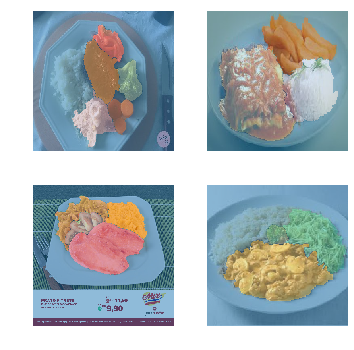

In [12]:
data.show_batch(2, figsize=(5,5), ds_type=DatasetType.Valid)

# TRAINING 

In [13]:
name2id = {v:k for k,v in enumerate(codes)} # faz uma lista que relaciona nome e id
void_code = name2id['void']

def acc_segmentation(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

# def dice_segmentation(input:Tensor, targs:Tensor, iou:bool=True)->Rank0Tensor:
#     "Dice coefficient metric for binary target. If iou=True, returns iou metric, classic for segmentation problems."
#     n = targs.shape[0]
#     mask = targs != void_code
#     input = input.argmax(dim=1)[mask]#.view(n,-1)
#     targs = targs[mask]#.view(n,-1)
#     intersect = (input * targs).sum().float()
#     union = (input+targs).sum().float()
#     if not iou: return (2. * intersect / union if union > 0 else union.new([1.]).squeeze())
#     else: return intersect / (union-intersect+1.0)

dice_segmentation = partial(dice, iou=True)

In [14]:
wd=1e-3
learn = unet_learner(data, models.resnet34, metrics=[acc_segmentation,dice_segmentation], wd=wd, callback_fns=ShowGraph).to_fp16()

In [15]:
learn.model[0].load_state_dict(torch.load(path + '/../resnet34_encoder-food101.h5'), strict=True); #load preTrained from FOOD101

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-04


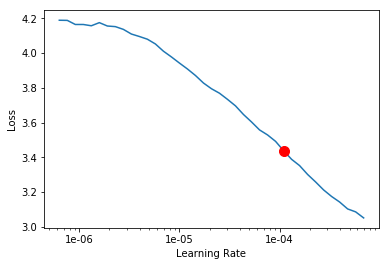

In [16]:
lr_find(learn)
learn.recorder.plot(suggestion=True)

In [17]:
# lr = 1e-4 # loss 3.8 para wd 1e-4
lr = 3e-4 # loss 2.4 para wd 1e-3
# lr = 1e-4 # loss 4.5 para wd 1e-2

epoch,train_loss,valid_loss,acc_segmentation,dice,time
0,3.164115,2.610966,0.014606,-1.783628,00:17
1,2.783397,2.244922,0.001092,0.614231,00:14
2,2.539196,2.009143,0.007187,2.293310,00:14
3,2.325680,1.757185,0.032028,-1.783989,00:14
4,2.155766,1.661120,0.055684,-1.429157,00:14
5,2.017273,1.580468,0.074272,-1.433513,00:14
6,1.898935,1.505672,0.101376,-1.424613,00:14
7,1.802062,1.436480,0.145762,-1.444349,00:14
8,1.723095,1.419760,0.188549,-1.395729,00:14
9,1.636701,1.349162,0.221339,-1.404862,00:14


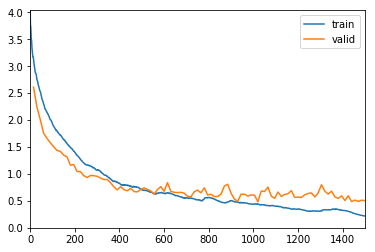

Better model found at epoch 0 with acc_segmentation value: 0.014605915173888206.
Better model found at epoch 3 with acc_segmentation value: 0.0320277065038681.
Better model found at epoch 4 with acc_segmentation value: 0.05568419769406319.
Better model found at epoch 5 with acc_segmentation value: 0.0742720514535904.
Better model found at epoch 6 with acc_segmentation value: 0.10137594491243362.
Better model found at epoch 7 with acc_segmentation value: 0.14576217532157898.
Better model found at epoch 8 with acc_segmentation value: 0.188548743724823.
Better model found at epoch 9 with acc_segmentation value: 0.22133870422840118.
Better model found at epoch 10 with acc_segmentation value: 0.28099149465560913.
Better model found at epoch 11 with acc_segmentation value: 0.3461135923862457.
Better model found at epoch 13 with acc_segmentation value: 0.4091348648071289.
Better model found at epoch 14 with acc_segmentation value: 0.43689650297164917.
Better model found at epoch 15 with acc_s

In [18]:
learn.fit_one_cycle(100, lr, pct_start=0.9,
                    callbacks=[SaveModelCallback(learn, every='improvement', monitor='acc_segmentation',
                                                 name='stage-1-best')])

In [19]:
# learn.load('stage-1-best')
# learn.save('stage-1-size350-bestEpoch',return_path=True)

PosixPath('database/done/models/stage-1-size350-bestEpoch.pth')

[0.48702335, tensor(0.7886), tensor(-1.1938)]


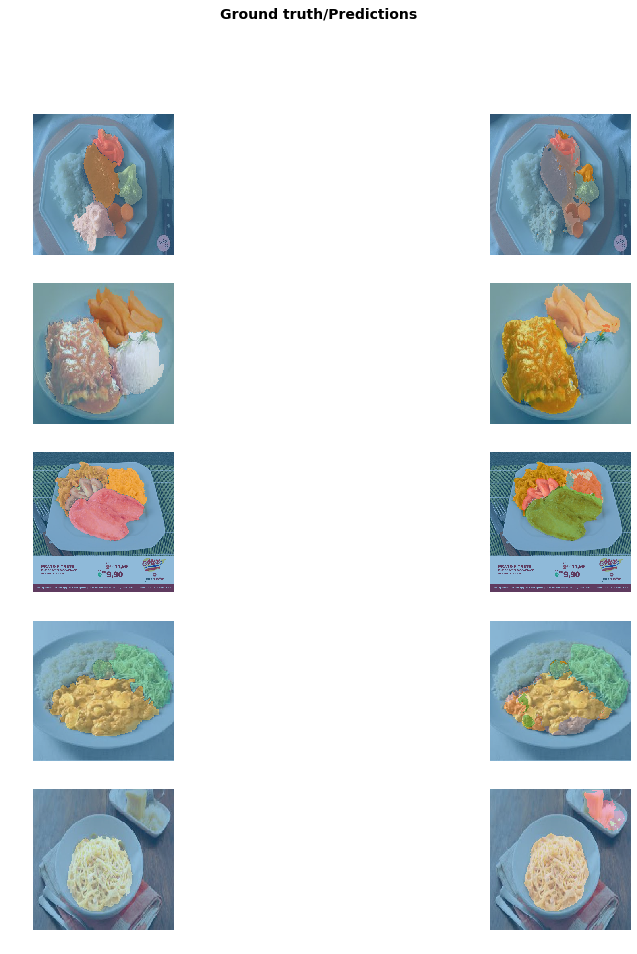

In [21]:
learn.load('stage-1-size350-bestEpoch')
print(learn.validate())
learn.show_results(figsize=(15,15))

# INTERPRETATION

In [ ]:
learn = unet_learner(data, models.resnet34, metrics=[acc_segmentation,dice], wd=wd)
#learn.load('stage-1-size7-8epochs')
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()
#interp.plot_top_losses(9, figsize=(15,11))


In [ ]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
interp.most_confused(min_val=10)

# FINE-TUNING

In [48]:
wd=1e-3
learn = unet_learner(data, models.resnet34, metrics=[acc_segmentation,dice_segmentation], wd=wd, callback_fns=ShowGraph).to_fp16()
learn.load('stage-1-size350-bestEpoch')
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.00E-05


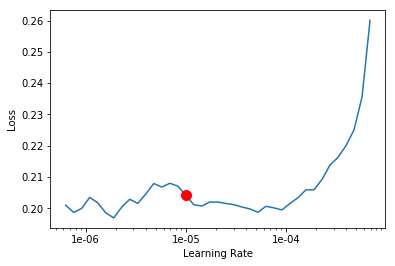

In [49]:
lr_find(learn)
learn.recorder.plot(suggestion=True)

In [53]:
# loss sempre crescente para wd 1e-4.
# loss 0.065 para wd 1e-3. Começa aumentar em lr = 1e-4
# loss 0.06 para wd 1e-2. Começa aumentar em lr = 1e-4
lrs = slice(lr/400,lr/4)
#lrs = slice(1e-5,1e-4)

epoch,train_loss,valid_loss,acc_segmentation,dice,time
0,0.150280,0.496532,0.812603,-1.188514,00:15
1,0.149330,0.493514,0.814599,-1.188632,00:15
2,0.144501,0.495085,0.813514,-1.188446,00:15
3,0.144183,0.513229,0.809337,-1.190156,00:15
4,0.143319,0.527489,0.808910,-1.189628,00:15
5,0.143132,0.514811,0.803531,-1.190385,00:15
6,0.142705,0.548630,0.784149,-1.196009,00:15
7,0.144215,0.581455,0.783655,-1.195338,00:15
8,0.143571,0.561069,0.787032,-1.191885,00:15
9,0.141132,0.546113,0.792840,-1.190316,00:15


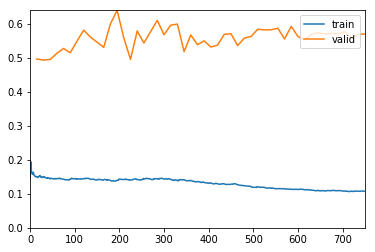

Better model found at epoch 0 with acc_segmentation value: 0.8126026391983032.
Better model found at epoch 1 with acc_segmentation value: 0.8145988583564758.
Better model found at epoch 14 with acc_segmentation value: 0.8244810700416565.


In [54]:
learn.fit_one_cycle(50, lrs, pct_start=0.3, 
callbacks=[SaveModelCallback(learn, every='improvement', monitor='acc_segmentation',
                                                 name='stage-2-best')])

In [55]:
# NAO SALVOU STAGE 2 POIS DEU OVERFITTING. PARAMETROS  DA CNN JA ESTAO BONS POIS VIERAM DO FOOD101
learn.load('stage-2-best')
learn.save('stage-2-size350-bestEpoch')

# POSPROCESSING

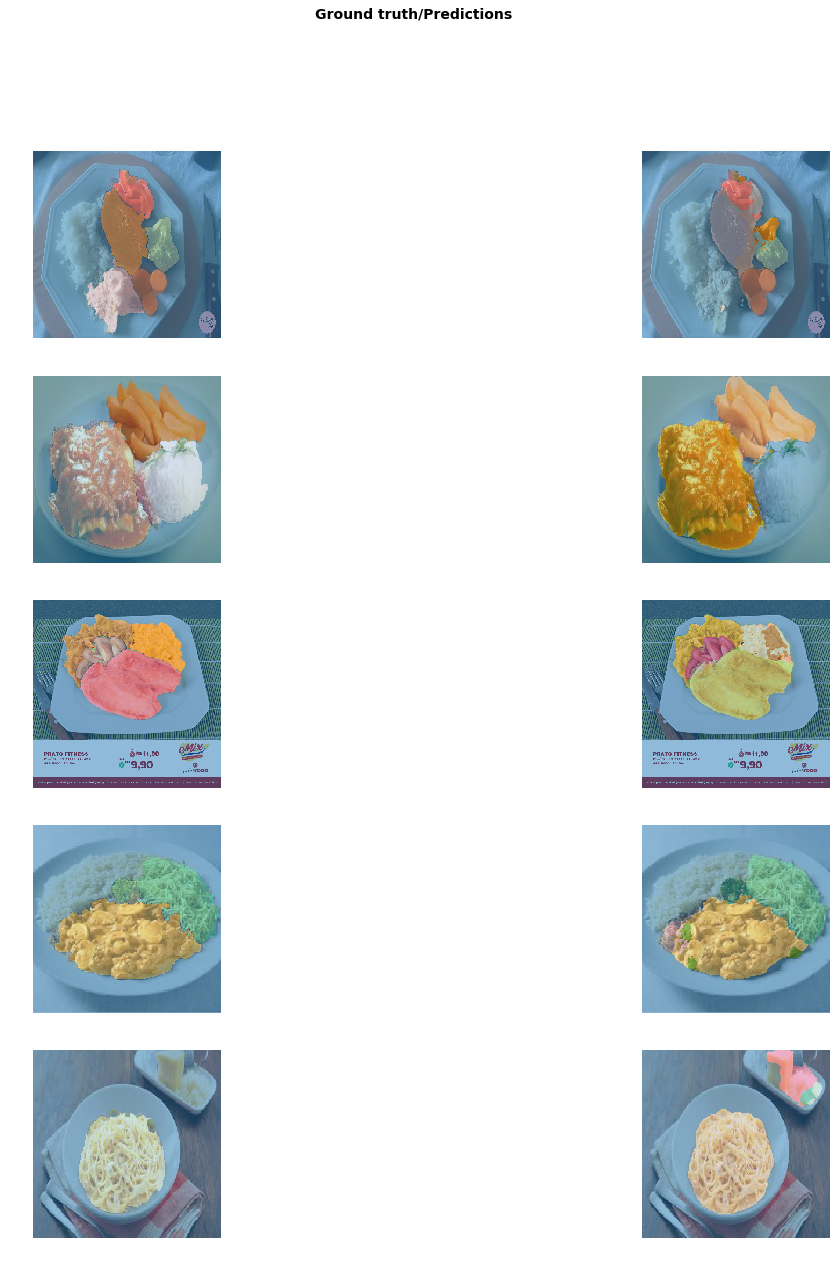

In [11]:
learn = unet_learner(data, models.resnet34, metrics=[]).to_fp16()
learn.load('stage-2-size350-bestEpoch') 
learn.show_results(figsize=(20,20))

In [12]:
id2name = {k:v for k,v in enumerate(codes)} # faz uma lista que relaciona nome e id
preds = learn.get_preds(ds_type=DatasetType.Valid)

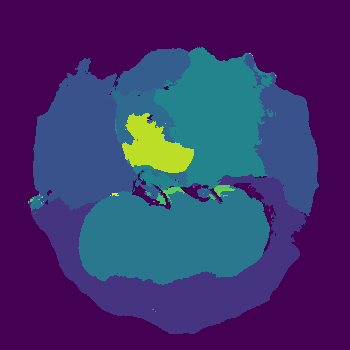

In [20]:
index = 20
pred = learn.predict(data.valid_ds.x[index])
pred[0]

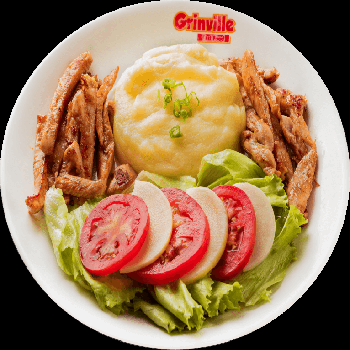

In [21]:
data.valid_ds.x[index]

In [22]:
predArray = pred[0].data.numpy() #imagem com os labels de cada pixel
predArray = np.squeeze(predArray,axis=0)
foods, counts = np.unique(predArray,return_counts=True)
counts = np.delete(counts, 0) #tira o void na posicao 0 do array
foods = np.delete(foods, 0) #tira o void na posicao 0 do array
foodNames = []
print(f'Numero de alimentos: {len(foods)}')
for food in foods:
    foodNames = np.append(foodNames,id2name[food])
print(dict(zip(foodNames, counts)))

Numero de alimentos: 16
{'arroz': 3, 'salada': 13806, 'frango': 15871, 'ovo': 2494, 'pure de batata': 2031, 'tomate': 14400, 'batata': 10969, 'farofa': 28, 'batata frita': 3, 'legumes': 27, 'pepino': 84, 'cenoura': 225, 'beterraba': 35, 'parmegiana': 4, 'strogonoff': 2474, 'linguica': 17}


./database/gt/88GT.png
Numero de alimentos: 5
{'salada': 15541, 'frango': 17860, 'pure de batata': 13611, 'tomate': 9930, 'batata': 5743}


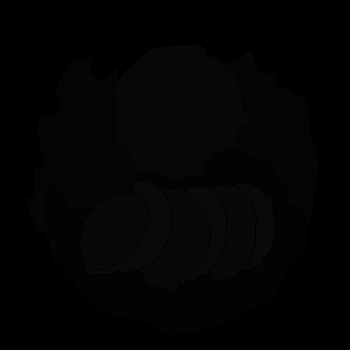

In [23]:
print(data.valid_ds.y.items[index])
imgTarget = Image.open(data.valid_ds.y.items[index])
img = imgTarget.resize(np.flip(size))
targArray = np.array(img)
foods, counts = np.unique(targArray,return_counts=True)
counts = np.delete(counts, 0) #tira o void na posicao 0 do array
foods = np.delete(foods, 0) #tira o void na posicao 0 do array
foodNames = []
print(f'Numero de alimentos: {len(foods)}')
for food in foods:
    foodNames = np.append(foodNames,id2name[food])
print(dict(zip(foodNames, counts)))
img

In [24]:
target = preds[1][index].data.numpy()
foods, counts = np.unique(target,return_counts=True)
counts = np.delete(counts, 0) #tira o void na posicao 0 do array
foods = np.delete(foods, 0) #tira o void na posicao 0 do array
accuracy = (target == predArray).mean()
print(accuracy)

0.7828734693877551


# PREDICTIONS

In [ ]:
learn = unet_learner(data, models.resnet34, metrics=[acc_segmentation,dice_segmentation])
learn.load('stage-1-size350-466-bestEpoch-accSemVoid') #melhor modelo foi sem unfreeze!
img = data.train_ds[0][0]
learn.predict(img);
img.show(y=learn.predict(img)[0])